In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.group_ts_split import GroupTimeSeriesSplit, PurgedGroupTimeSeriesSplit
from sklearn.linear_model import LinearRegression
import pickle
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from utils.util_functions import import_data
from sklearn import preprocessing

In [63]:
df_train = import_data('data/extra_train.csv')
# drop brackets from column names
df_train.columns = df_train.columns.str.replace('[', '', regex=False)
df_train.columns = df_train.columns.str.replace(']', '', regex=False)
df_train.columns = df_train.columns.str.replace(' ', '_', regex=False)
df_train

Memory usage of dataframe is 8.66 MB
Memory usage after optimization is: 2.29 MB
Decreased by 73.6%


,Month,Hour,cons_target,Solar_Generation_W/kW,Outdoor_Drybulb_Temperature_C,Relative_Humidity_%,Diffuse_Solar_Radiation_W/m2,Direct_Solar_Radiation_W/m2,day_year,number,...,net_target,net+1,net-23,net_target+1,net_target-23,net_target_diff,diffuse_solar_radiation+1,direct_solar_radiation+1,relative_humidity+1,drybulb_temp+1
0,8,0,0.441406,0.000000,19.406250,81.0,0.000000,0.000000,23,1,...,0.617188,1.411133,2.275391,0.431885,0.506836,-0.029327,0.000000,0.000,81.0,20.000000
1,8,1,0.170776,0.000000,20.000000,81.0,0.000000,0.000000,24,1,...,0.431885,0.979492,0.851074,0.394531,0.383301,-0.185547,0.000000,0.000,87.0,19.406250
2,8,2,0.116333,0.000000,19.406250,87.0,0.000000,0.000000,25,1,...,0.394531,0.900879,0.834473,0.387695,0.382080,-0.037354,0.000000,0.000,87.0,19.406250
3,8,3,0.106445,0.000000,19.406250,87.0,0.000000,0.000000,26,1,...,0.387695,0.922363,0.838379,0.389648,0.382324,-0.006783,0.000000,0.000,90.0,19.406250
4,8,4,0.109131,0.000000,19.406250,90.0,0.000000,0.000000,27,1,...,0.389648,0.910645,1.478516,0.388428,0.437744,0.001856,0.000000,0.000,90.0,18.906250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43675,7,19,0.802734,31.171875,21.093750,81.0,5.390625,5.667969,8754,5,...,0.862305,2.714844,3.462891,0.720703,0.814941,0.090393,3.294922,4.875,84.0,20.593750
43676,7,20,0.552734,4.070312,20.593750,84.0,3.294922,4.875000,8755,5,...,0.720703,0.936035,0.457275,0.497803,0.437744,-0.141235,0.000000,0.000,81.0,21.093750
43677,7,21,0.189453,0.000000,21.093750,81.0,0.000000,0.000000,8756,5,...,0.497803,2.154297,0.714844,0.650879,0.469971,-0.223145,0.000000,0.000,79.0,21.703125
43678,7,22,0.436279,0.000000,21.703125,79.0,0.000000,0.000000,8757,5,...,0.650879,2.316406,1.659180,0.670898,0.588379,0.152954,0.000000,0.000,76.0,21.296875


In [64]:
X = df_train.drop(['number', 'net', 'day_year', 'Month', 'Hour'], axis=1)
# X_temp = X.drop(['net+1', 'net_target+1', 'net-23', 'Solar_Generation_W/kW',
#        'Outdoor_Drybulb_Temperature_C', 'Relative_Humidity_%',
#        'Diffuse_Solar_Radiation_W/m2', 'Direct_Solar_Radiation_W/m2', 'net_target_diff','cons_target'], axis=1)
X_temp = X.drop(['net+1', 'net_target+1', 'net-23', 'Solar_Generation_W/kW',
       'Outdoor_Drybulb_Temperature_C', 'Relative_Humidity_%',
       'Diffuse_Solar_Radiation_W/m2', 'Direct_Solar_Radiation_W/m2', 'net_target_diff','cons_target', 'net_target'], axis=1)
features = X_temp.columns
features
y = df_train['net_target+1']
groups = df_train['day_year'].values
X_temp

,hour_x,hour_y,month_x,month_y,net_target-23,diffuse_solar_radiation+1,direct_solar_radiation+1,relative_humidity+1,drybulb_temp+1
0,1.000000,0.000000,-0.500000,-0.866211,0.506836,0.000000,0.000,81.0,20.000000
1,0.965820,0.258789,-0.500000,-0.866211,0.383301,0.000000,0.000,87.0,19.406250
2,0.866211,0.500000,-0.500000,-0.866211,0.382080,0.000000,0.000,87.0,19.406250
3,0.707031,0.707031,-0.500000,-0.866211,0.382324,0.000000,0.000,90.0,19.406250
4,0.500000,0.866211,-0.500000,-0.866211,0.437744,0.000000,0.000,90.0,18.906250
...,...,...,...,...,...,...,...,...,...
43675,0.258789,-0.965820,-0.866211,-0.500000,0.814941,3.294922,4.875,84.0,20.593750
43676,0.500000,-0.866211,-0.866211,-0.500000,0.437744,0.000000,0.000,81.0,21.093750
43677,0.707031,-0.707031,-0.866211,-0.500000,0.469971,0.000000,0.000,79.0,21.703125
43678,0.866211,-0.500000,-0.866211,-0.500000,0.588379,0.000000,0.000,76.0,21.296875


In [65]:
# define the LinearRegression class with the feature_name property
class MyLinearRegression(LinearRegression):
    @property
    def feature_name(self):
        return self.features

# train a linear regression model
model = MyLinearRegression()
model.fit(X_temp.values, y)

# create an attribute in model to store the feature names
model.features = list(features)

# save the model using joblib
joblib.dump(model, 'models/point/lr.pkl')

['models/point/lr.pkl']

In [58]:
list(features)

['hour_x',
 'hour_y',
 'month_x',
 'month_y',
 'net_target',
 'net_target-23',
 'diffuse_solar_radiation+1',
 'direct_solar_radiation+1',
 'relative_humidity+1',
 'drybulb_temp+1']

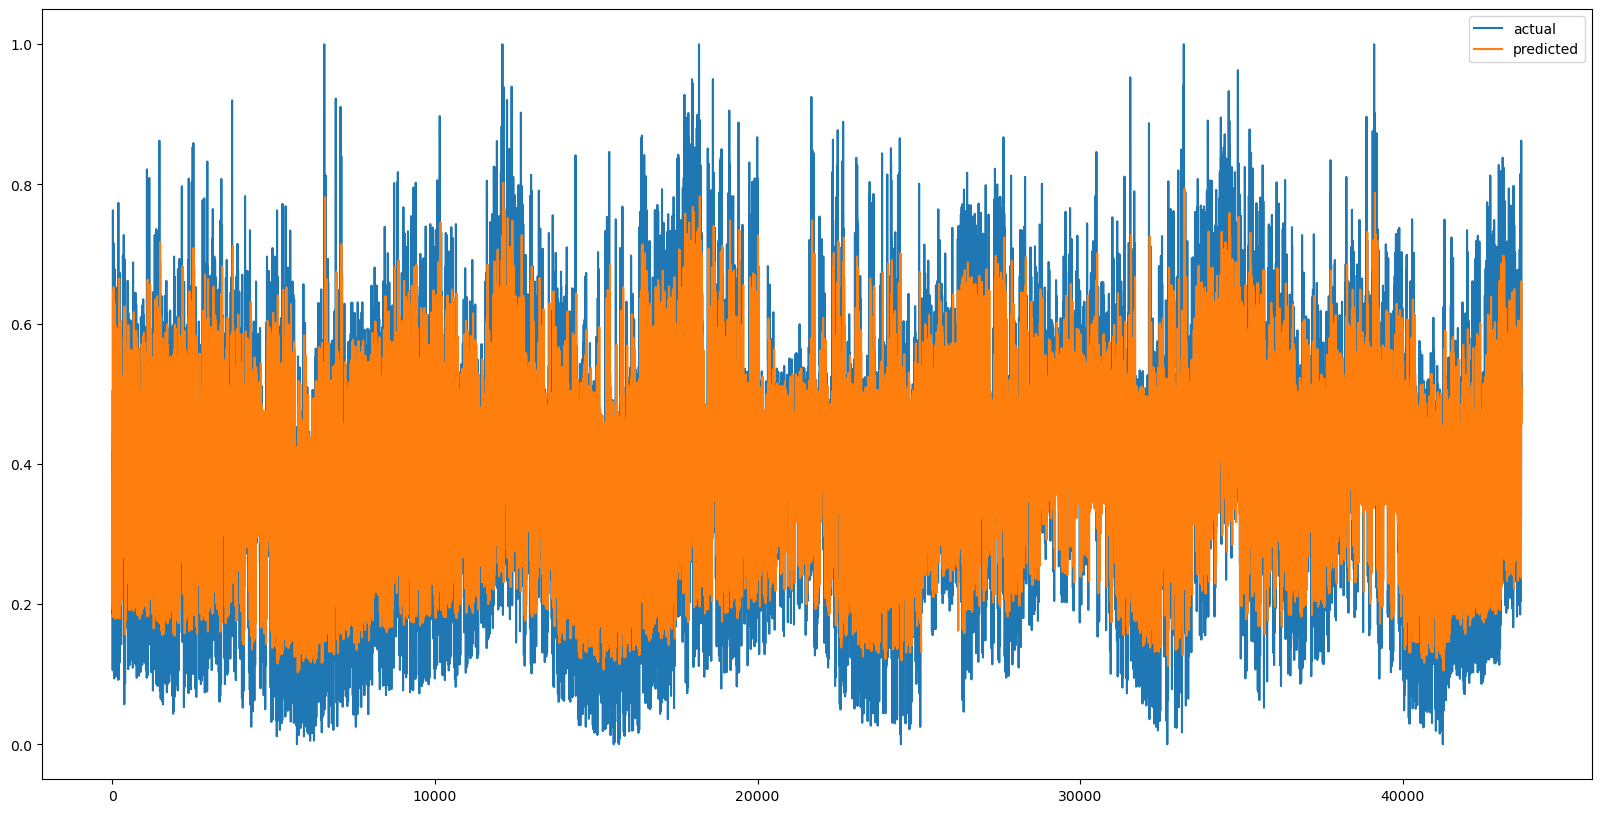

In [21]:
# plot linear regression fit
plt.figure(figsize=(20,10))
plt.plot(y, label='actual')
plt.plot(model.predict(X_temp), label='predicted')
plt.legend()
plt.show()
